In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.models
from keras.layers.convolutional import Conv1D, Conv2D, ZeroPadding1D, ZeroPadding2D
from keras.layers.recurrent import Recurrent, LSTM, GRU
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from math import floor, ceil
from sklearn.metrics import accuracy_score
% matplotlib inline

# prepare inputs

In [149]:
def load_and_format_data():
    # load data
    dataset = 'train/1'
    x_data = pd.read_csv(dataset + '.train.calcium.csv')
    y_data = pd.read_csv(dataset + '.train.spikes.csv')
    x_train = x_data['0'].dropna()  # todo: concat these
    y_train = y_data['0'].dropna()
    for i in range(1,8):
        x_train = np.concatenate((x_train,x_data[str(i)].dropna()))
        y_train = np.concatenate((y_train,y_data[str(i)].dropna()))
    x_test = pd.read_csv(dataset + '.train.calcium.csv')['9'].dropna()  # todo: concat these
    y_test = pd.read_csv(dataset + '.train.spikes.csv')['9'].dropna()
    num_y = int(np.max(y_train+1))
    # binarize labels
    lb = LabelBinarizer()
    lb.fit(y_train) # this lb takes 0 -> [1,0,0,0,0], 1-> [0,1,0,0,0], etc.
    y_train = lb.transform(y_train)
#     y_test = lb.transform(y_test)
    # reshape data
    x_train = x_train.reshape((1, len(x_train), 1))
    y_train = y_train.reshape((1, len(y_train), y_train.shape[1]))
    x_test = x_test.values.reshape((1, len(x_test), 1))
#     y_test = y_test.reshape((1, len(y_test), y_test.shape[1]))
    return x_train, y_train, x_test, y_test, num_y
x_train, y_train, x_test, y_test, num_y = load_and_format_data()
print("train, test sizes",x_train.shape,x_test.shape)

train, test sizes (1, 539893, 1) (1, 59717, 1)


# create model

In [150]:
max_features = 10
embedding_dims = 10
kernel_sizes = [21,13,5] # should be odd
pad_sizes = [floor(s/2) for s in kernel_sizes]
model = keras.models.Sequential()
model.add(ZeroPadding1D(padding=pad_sizes[0], input_shape=(None, 1)))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[0], activation="linear"))
model.add(ZeroPadding1D(padding=pad_sizes[1], input_shape=(None, 1)))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[1], activation="linear"))
# model.add(ZeroPadding1D(padding=pad_sizes[2], input_shape=(None, 1)))
# model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[2], activation="softmax"))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [151]:
num_y
y_train.shape

(1, 539893, 6)

# fit the model

In [152]:
epochs = 100
model.fit(x_train, y_train, epochs=epochs, verbose=1)

Epoch 1/100
1/1 [==============================] - 0s - loss: 0.1674 - acc: 0.4020
Epoch 2/100
1/1 [==============================] - 0s - loss: 0.1560 - acc: 0.5629
Epoch 3/100
1/1 [==============================] - 0s - loss: 0.1443 - acc: 0.7144
Epoch 4/100
1/1 [==============================] - 0s - loss: 0.1333 - acc: 0.8161
Epoch 5/100
1/1 [==============================] - 0s - loss: 0.1232 - acc: 0.8748
Epoch 6/100
1/1 [==============================] - 0s - loss: 0.1139 - acc: 0.9072
Epoch 7/100
1/1 [==============================] - 0s - loss: 0.1053 - acc: 0.9250
Epoch 8/100
1/1 [==============================] - 0s - loss: 0.0976 - acc: 0.9353
Epoch 9/100
1/1 [==============================] - 0s - loss: 0.0906 - acc: 0.9415
Epoch 10/100
1/1 [==============================] - 0s - loss: 0.0844 - acc: 0.9458
Epoch 11/100
1/1 [==============================] - 0s - loss: 0.0790 - acc: 0.9487
Epoch 12/100
1/1 [==============================] - 0s - loss: 0.0743 - acc: 0.9508
E

# evaluate

In [153]:
print('predict...')
y_pred = np.argmax(model.predict(x_test)[0,:,:],axis=1)
print('y_pred nonzeros',str(np.sum(y_pred) / y_pred.size))
print("acc",accuracy_score(y_pred,y_test))
print("corr",np.corrcoef(y_pred,y_test)[0,1])

# evaluate the model
print('evaluating...')

predict...
y_pred nonzeros 0.0
acc 0.9868211732
corr nan
evaluating...


# visualize

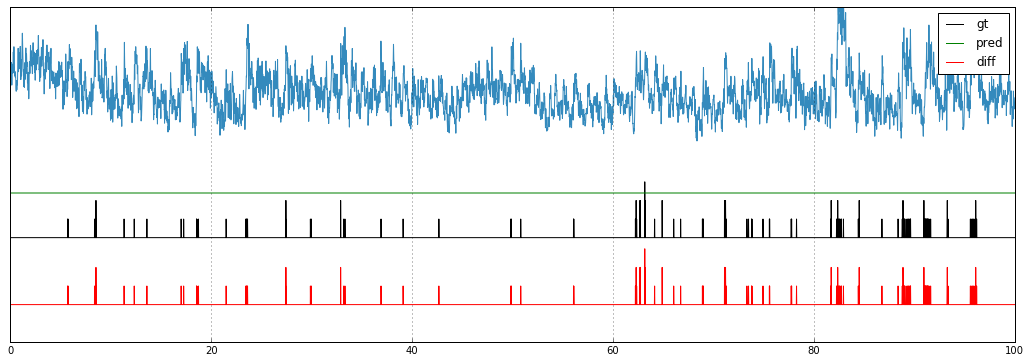

In [154]:
def visualize(calcium, spikes, spikes2=np.zeros(1)):
    t = np.arange(len(calcium)) / 100.0
    plt.figure(figsize=(18, 6))
    plt.hold(True)
    plt.plot(t, calcium, color='#348ABD')
    plt.plot(t, spikes / 2.0 - 3.2, color='black',label='gt')
    if not np.sum(spikes)==0:
        plt.plot(t, spikes2 / 2.0 - 2, color='g',label='pred')
        plt.plot(t, (spikes-spikes2) / 2.0 - 5, color='r',label='diff')
    plt.yticks([])
    plt.ylim([-6, 3])
    plt.xlim([0,100])
    plt.grid()
    plt.legend()
    plt.show()

visualize(x_test[0,:,0],y_test,y_pred)